In [2]:
import os
import wandb
import torch
import joblib
import datetime
import numpy as np
import torch.nn as nn

# training utilities
import train_utils
from config.config_base_model import Config, model_config_builder_transformer, model_config_builder_actp, model_config_builder_svg

# models
from model_set.transformer import VPGPT
from model_set.SPOTS_SVG_ACTP_SOP import Model as SPOTS_SVG_ACTP_SOP
from model_set.SPOTS_SVG_ACTP import Model as SPOTS_SVG_ACTP
from model_set.SVG import Model as SVG

# data loading and processing
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# data logging and visualization
from absl import app, logging, flags


In [98]:
sample_rate        = 20
context_len        = 10
prediction_horizon = 10
to_replace         = "/media/wmandil/Data/Robotics/Data_sets/single_object_velocity_controlled_dataset/single_object_velocity_controlled_dataset/"
replace_with       = "/home/wmandil/robotics/datasets/robot_pushing/"

map_data = np.load("/home/wmandil/robotics/datasets/robot_pushing/train/formatted_dataset/map.npy", allow_pickle=True)
map_data = map_data[:10]

total_sequences = 0
sequences = []
for episode in map_data:
    episode_length = episode['episode_length']
    valid_sequences = episode_length - ((context_len + prediction_horizon - 1)*sample_rate)
    if valid_sequences > 0:
        total_sequences += valid_sequences
        sequences += episode['step_save_name_list'][context_len + prediction_horizon - 1:]  #  TODO not needed for pre-loaded datasets and needs a fix for sample_rate stuff 

data = []
sample_index_list = []
current_index = 0
for episode in tqdm(map_data, desc="Loading data", dynamic_ncols=True):
    episode_length = episode['episode_length']
    for step_num, save_name in enumerate(episode['step_save_name_list']):
        save_name = save_name.replace(to_replace, replace_with)            # overwrite location if it has changed:
        step_data = np.load(save_name, allow_pickle=True)
        robot_state  = step_data[()]["state"]
        image_data   = step_data[()]['image'].transpose(2, 0, 1)
        tactile_data = step_data[()]['tactile']
        if episode_length - step_num >= (context_len + prediction_horizon - 1)*sample_rate:
            sample_index_list += [current_index]
        current_index += 1
        data.append([robot_state, image_data, tactile_data])

Loading data: 100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


In [99]:
def getitem(idx):
    start_index = sample_index_list[idx]
    robot_state, image_data, tactile_data = [], [], []
    for i in range(0, (context_len + prediction_horizon)*sample_rate, sample_rate):
        step_data = data[start_index + i]
        robot_state.append(step_data[0])
        image_data.append(step_data[1].astype(np.float32) / 255)
        tactile_data.append(step_data[2].flatten())

    robot_state  = np.stack(robot_state, axis=0)
    image_data   = np.stack(image_data, axis=0)
    tactile_data = np.stack(tactile_data, axis=0)

    return torch.tensor(robot_state), torch.tensor(image_data) , torch.tensor(tactile_data)

/tmp/ipykernel_11008/2554517192.py:49: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


[]


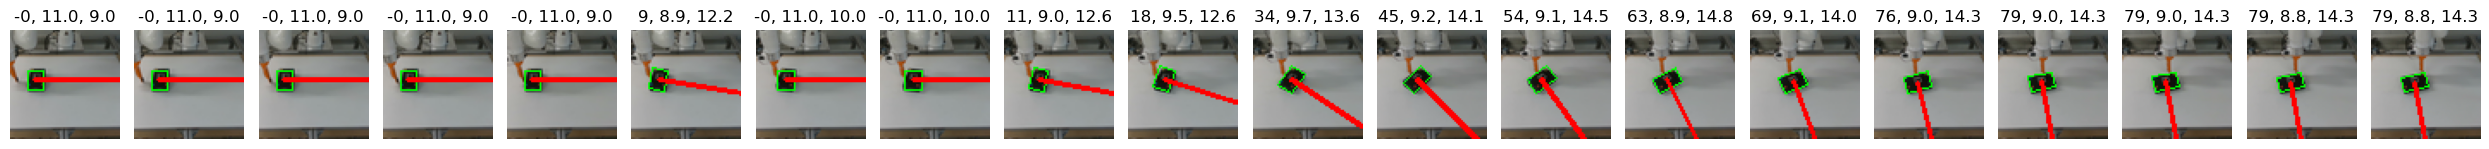

/tmp/ipykernel_11008/2554517192.py:49: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


[]


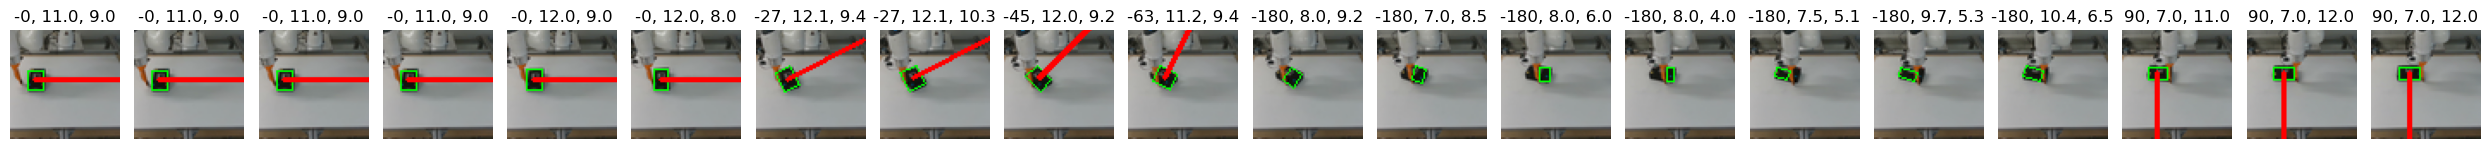

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

box_area_threshold = 18.0

for item in [20, 800]:
    angles = []
    images_and_angles = []
    robot_state, images, tactiles = getitem(item)
    for image in images:
        image_corrected = image.permute(1, 2, 0).cpu().numpy()

        image_corrected = (image_corrected * 255).astype(np.uint8)

        # flip image rgb to bgr
        image_corrected = cv2.cvtColor(image_corrected, cv2.COLOR_RGB2BGR)

        # create a binary image
        imageGray = cv2.cvtColor(image_corrected, cv2.COLOR_RGB2GRAY)

        # black out top third and bottom third of image
        imageGray[:int(imageGray.shape[0]/4)] = 255
        imageGray[int(imageGray.shape[0]*3/4):] = 255

        # thresh the image
        thresh = cv2.threshold(imageGray, 35, 255, cv2.THRESH_BINARY_INV)[1]

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            rotated_rect = cv2.minAreaRect(largest_contour)

            angle = rotated_rect[-1]

            # Calculate the width and height of the rectangle
            width = rotated_rect[1][0]
            height = rotated_rect[1][1]

            # Adjust the angle to be within [-90, 90]
            if width < height:  # Long side is vertical
                if angle < -45:
                    angle = 90 + angle
            elif width > height:  # Long side is horizontal
                if angle > 0:
                    angle = -(90 - angle)

            box = cv2.boxPoints(rotated_rect)
            box = np.int0(box)
            cv2.drawContours(image_corrected, [box], 0, (0, 255, 0), 1)

            if width + height < box_area_threshold:
                angle = -180
            else:
                center = (int(rotated_rect[0][0]), int(rotated_rect[0][1]))
                angle_rad = np.deg2rad(angle)
                x = int(center[0] + np.cos(angle_rad) * 50)
                y = int(center[1] + np.sin(angle_rad) * 50)
                cv2.line(image_corrected, center, (x, y), (255, 0, 0), 2)

        images_and_angles.append([image_corrected, angle, rotated_rect[1][0], rotated_rect[1][1]])

    print(angles)
    fig, ax = plt.subplots(1, len(images_and_angles), figsize=(25, 5))
    for i, (image_corrected, angle, height, width) in enumerate(images_and_angles):
        ax[i].imshow(image_corrected)
        ax[i].set_title("{:.0f}, {:.1f}, {:.1f}".format(angle, height, width))
        # remove ticks and labels
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])
        ax[i].tick_params(left=False, bottom=False)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()


In [122]:
rotated_rect[1]

(8.825225830078125, 14.31647777557373)